In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import RocCurveDisplay 

# Przygotowanie danych

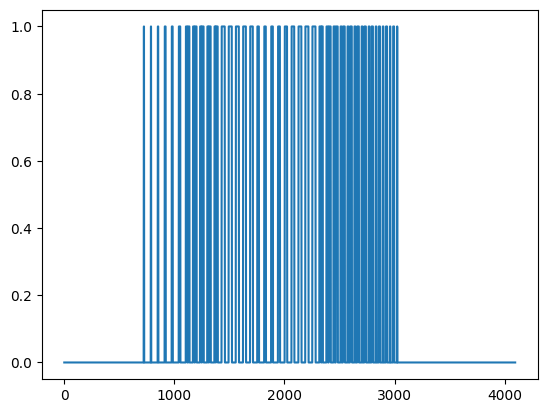

Wymiar danych: [ 1420 ,  4096 ]
Unikalne etykiety:  ['angleCross' 'ellipse' 'hexagon' 'line' 'square' 'straightCross'
 'triangle']


In [102]:
# wczytujemy dane - cechy i etykiety w osobnych plikach
file_x = 'X_figures.npy'
file_y = 'y_figures.npy'

X = np.load(file_x)
y = np.load(file_y)
# rysowanie przykładowych danych
plt.plot(X[17,:])
plt.show()
# sprawdzamy wymiar danych
print("Wymiar danych: [",len(X), ", ", len(X[1,:]), "]")
# sprawdzamy postać etykiet
print("Unikalne etykiety: ", np.unique(y))
# z tego wynika, że zbiór cech to zbiór składający się z 0 i 1 i ma wymiar [1420, 4096]

In [103]:
# konwertujemy nparray do dataframe dla wygody
df_X = pd.DataFrame(X)
df_y = pd.DataFrame(y, columns=['label'])
# sprawdzamy liczebność klas
print("Liczebność klas:\n", df_y['label'].value_counts())
# zatem najmniej liczebna jest klasa triangle a najwięcej elementów ma klasa straightCross

Liczebność klas:
 label
straightCross    240
line             220
angleCross       200
hexagon          200
ellipse          200
square           200
triangle         160
Name: count, dtype: int64


In [104]:
# sprawdzamy jeszcze czy dane są wybrakowane
print("Liczba brakujących wartości w cechach:\n", df_X.isnull().sum().sum())
print("Liczba brakujących wartości w etykietach:\n", df_y.isnull().sum().sum())
# nie ma brakujących wartości

Liczba brakujących wartości w cechach:
 0
Liczba brakujących wartości w etykietach:
 0


# Analiza PCA

Skumulowana wariancja wyjaśniana przez pierwsze 19 składowych (bez skalowania):
 [0.14702596 0.19643157 0.23874951 0.26899506 0.29474028 0.31562975
 0.3363633  0.35645553 0.37620168 0.39326717 0.40934408 0.42366318
 0.43623456 0.44814199 0.45989724 0.47104134 0.48129392 0.49121572
 0.50091052]


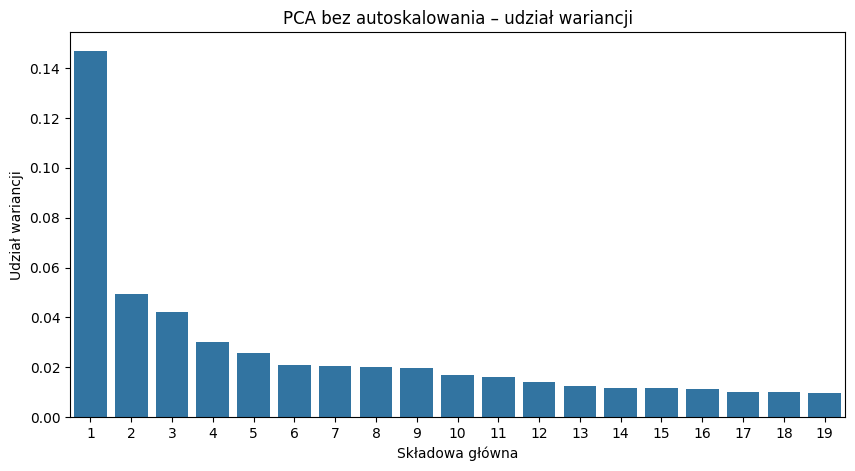

In [105]:
# ponieważ dane są wielowymiarowe, zastosujemy PCA do redukcji tej wymiarowości
# nie skalujemy danych, ponieważ zbiór składa się z 0 i 1 i skalowanie nie ma sensu
pca = PCA()
X_pca = pca.fit_transform(X)
# sprawdzamy wariancję wyjaśnianą przez kolejne składowe
lim = 20 # zmniejszamy ilość składowych do wyświetlenia (jest ich bardzo dużo)
cum_var_raw = np.cumsum(pca.explained_variance_ratio_[:lim-1])
print("Skumulowana wariancja wyjaśniana przez pierwsze", lim-1, "składowych (bez skalowania):\n", cum_var_raw)
plt.figure(figsize=(10,5))
sns.barplot(x=np.arange(1, lim), y=pca.explained_variance_ratio_[:lim-1])
plt.title("PCA bez autoskalowania – udział wariancji")
plt.xlabel("Składowa główna")
plt.ylabel("Udział wariancji")
plt.show()
# ten wykres jest mało czytelny dla tego zbioru danych więc narysujemy skumulowany

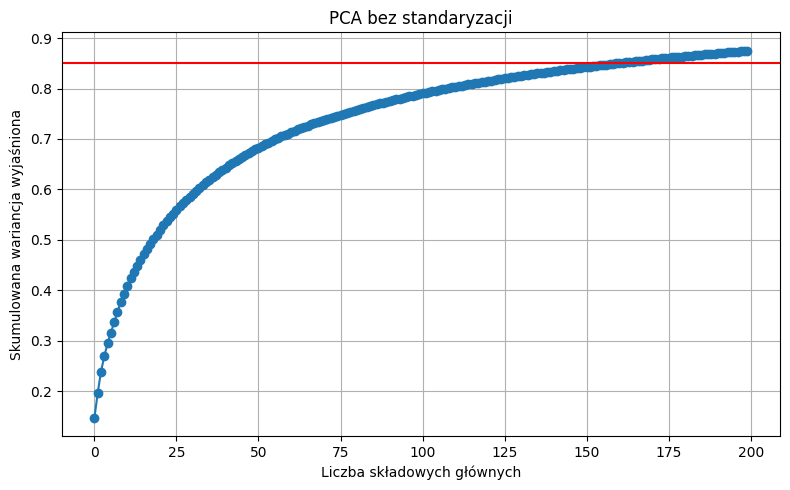

In [106]:
explained_variance = pca.explained_variance_ratio_
lim2 = 200 # zmniejszamy ilość składowych do wyświetlenia
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance[:lim2]), marker='o')
plt.xlabel('Liczba składowych głównych')
plt.ylabel('Skumulowana wariancja wyjaśniona')
plt.title('PCA bez standaryzacji')
plt.grid()
# zaznaczamy poziom wariancji 85%
plt.axhline(y=0.85, color='red')
plt.tight_layout()
plt.show()
# widzimy, że aby wyjaśnić 85% wariancji potrzebujemy około 160 składowych głównych

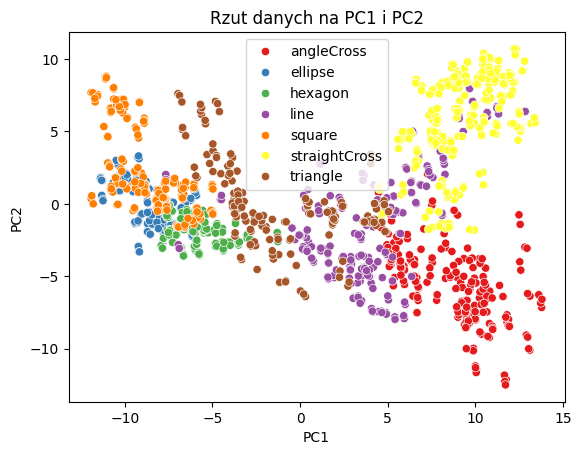

In [107]:
# rysujemy rzut danych na dwie pierwsze składowe główne
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='Set1')
plt.title("Rzut danych na PC1 i PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
# mimo to dane nie są dobrze rozdzielone na klasy, ale można rozdzielić klasę square i angleCross

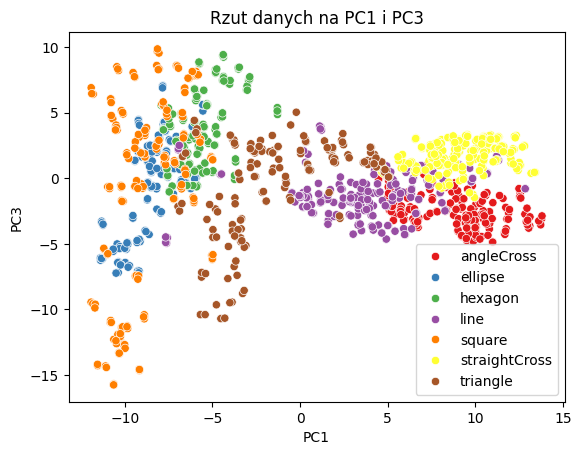

In [108]:
# spróbujemy rzutować na inne dwie składowe główne
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,2], hue=y
, palette='Set1')
plt.title("Rzut danych na PC1 i PC3")
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.show()
# tutaj można odseparować już trochę lepiej
# oddzielić można klasy straightCross, line, angleCross i triangle

# Algorytm SVM

In [109]:
# dzielimy dane na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

In [110]:
# przed rozpoczęciem klasyfikacji możemy spróbować dobrać optymalne parametry klasyfikatora SVM za pomocą GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# definiujemy siatkę parametrów do przeszukania
param_grid={'degree': [2, 3, 4],'C': [10, 1, 0.1, 0.01], 'gamma': [1, 10, 11]}
# przyjmujemy jądro wielomianowe i oceniamy na podstawie accuracy 
clf = GridSearchCV(estimator=SVC(kernel='poly'), param_grid=param_grid, cv=5, verbose=3, scoring='accuracy') 
clf.fit(X_train, y_train)
print('Best: ', clf.best_score_)
print('Best: ', clf.best_params_)
# najlepsze parametry to: C = 10, degree = 2, gamma = 1

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ...........C=10, degree=2, gamma=1;, score=0.935 total time=   0.2s
[CV 2/5] END ...........C=10, degree=2, gamma=1;, score=0.955 total time=   0.2s
[CV 3/5] END ...........C=10, degree=2, gamma=1;, score=0.935 total time=   0.2s
[CV 4/5] END ...........C=10, degree=2, gamma=1;, score=0.940 total time=   0.2s
[CV 5/5] END ...........C=10, degree=2, gamma=1;, score=0.934 total time=   0.2s
[CV 1/5] END ..........C=10, degree=2, gamma=10;, score=0.935 total time=   0.2s
[CV 2/5] END ..........C=10, degree=2, gamma=10;, score=0.955 total time=   0.2s
[CV 3/5] END ..........C=10, degree=2, gamma=10;, score=0.935 total time=   0.2s
[CV 4/5] END ..........C=10, degree=2, gamma=10;, score=0.940 total time=   0.3s
[CV 5/5] END ..........C=10, degree=2, gamma=10;, score=0.934 total time=   0.4s
[CV 1/5] END ..........C=10, degree=2, gamma=11;, score=0.935 total time=   0.3s
[CV 2/5] END ..........C=10, degree=2, gamma=11

In [111]:
# na podstawie wyników GridSearchCV tworzymy klasyfikator SVM z parametrami: C = 10, degree = 2, gamma = 1
from sklearn.svm import SVC
svm_classifier = SVC(kernel='poly', degree=2, C=10, gamma=1, random_state=42)
svm_classifier.fit(X_train, y_train)
y_test_svm_pred = svm_classifier.predict(X_test)
print(classification_report(y_test,y_test_svm_pred))
# na podstawie metryk można zauważyć, że klasyfikator radzi sobie całkiem nieźle
# wartości są powyżej 90% dla każdej klasy poza triangle, gdzie f1-score jest na poziomie 88%

               precision    recall  f1-score   support

   angleCross       0.94      0.94      0.94        50
      ellipse       0.98      0.92      0.95        63
      hexagon       0.91      0.98      0.95        64
         line       0.86      0.97      0.91        58
       square       0.98      1.00      0.99        59
straightCross       1.00      1.00      1.00        80
     triangle       0.98      0.81      0.88        52

     accuracy                           0.95       426
    macro avg       0.95      0.95      0.95       426
 weighted avg       0.95      0.95      0.95       426



In [112]:
# przeprowadzamy walidację krzyżową modelu
# ma to na celu sprawdzenie, czy podział zbioru miał wpływ na to jak poradził sobie klasyfikator
scores = cross_val_score(svm_classifier, X, y, cv=6) 
print('Accuracy: ', scores) 
print('Accuracy (mean): ', scores.mean()) 
print('Accuracy (std): ', scores.std()) 
# średnio otrzymujemy accuracy na poziomie 94%, czyli podział nie wpłynął na wynik

Accuracy:  [0.97046414 0.90295359 0.98312236 0.89029536 0.94915254 0.94915254]
Accuracy (mean):  0.9408567546306229
Accuracy (std):  0.03364947676641511


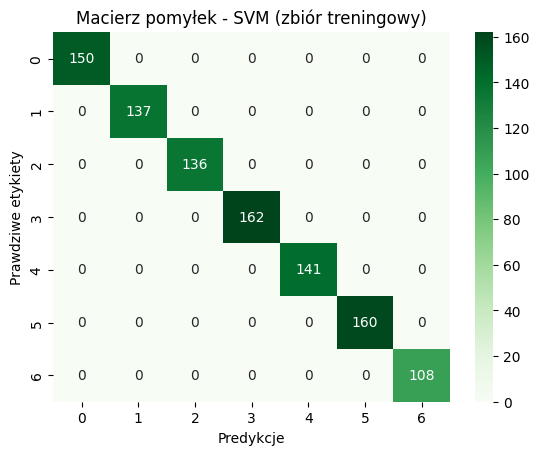


Accuracy (train SVM): 1.0


In [113]:
# wyrysowujemy macierz pomyłek dla zbioru treningowego
svm_train = confusion_matrix(y_train, svm_classifier.predict(X_train))
sns.heatmap(svm_train, annot=True, fmt='d', cmap='Greens')
plt.title('Macierz pomyłek - SVM (zbiór treningowy)')
plt.xlabel('Predykcje')
plt.ylabel('Prawdziwe etykiety')
plt.show()
print('\nAccuracy (train SVM):', accuracy_score(y_train, svm_classifier.predict(X_train)))
# widzimy, że model poradził sobie bezbłędnie

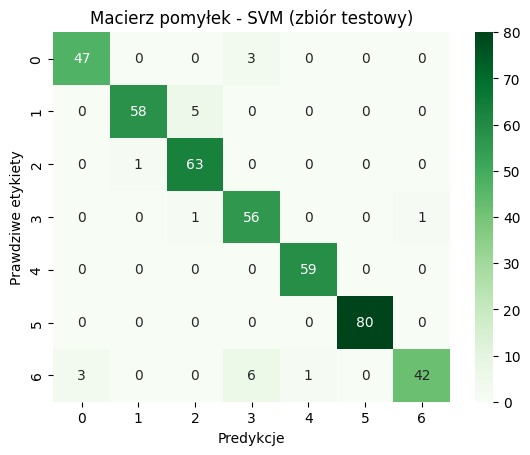


Accuracy (test SVM): 0.9507042253521126


In [114]:
# porównujemy ze zbiorem testowym
svm_train = confusion_matrix(y_test, svm_classifier.predict(X_test))
sns.heatmap(svm_train, annot=True, fmt='d', cmap='Greens')
plt.title('Macierz pomyłek - SVM (zbiór testowy)')
plt.xlabel('Predykcje')
plt.ylabel('Prawdziwe etykiety')
plt.show()
print('\nAccuracy (test SVM):', accuracy_score(y_test, svm_classifier.predict(X_test)))
# tutaj już pojedyncze wartości zostały źle sklasyfikowane, ale accuracy jest na poziomie 95%

Model nie jest przeuczony i dobrze dopasowuje się do danych. Jest bezbłędny w zbiorze treningowym i prawie bezbłędny w testowym. Nieco mniejsza precyzja w zbiorze testowym świadczy o tym, że nie jest przeuczony.

# Sprawdzamy drugi klasyfikator: Lasy losowe

In [115]:
# bierzemy drugi klasyfikator - las losowy
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42) #liczba estymatorów dobrana empirycznie
rf_classifier.fit(X_train, y_train)
y_test_rf_pred = rf_classifier.predict(X_test)
y_train_rf_pred = rf_classifier.predict(X_train)
print("Accuracy (train): ", accuracy_score(y_train, y_train_rf_pred))
print("Accuracy (test): ", accuracy_score(y_test, y_test_rf_pred))
# las losowy również radzi sobie bardzo dobrze na tym zbiorze danych, ale trochę gorzej niż SVM


Accuracy (train):  1.0
Accuracy (test):  0.892018779342723


In [116]:
# robimy walidację krzyżową dla lasu losowego
scores_rf = cross_val_score(rf_classifier, X, y, cv=6)
print('Accuracy RF: ', scores_rf)
print('Accuracy RF (mean): ', scores_rf.mean())
print('Accuracy RF (std): ', scores_rf.std())
#również podział zbioru nie miał większego wpływu na wynik

Accuracy RF:  [0.93248945 0.91139241 0.97046414 0.8649789  0.94491525 0.93644068]
Accuracy RF (mean):  0.9267801377863597
Accuracy RF (std):  0.032708998017073825


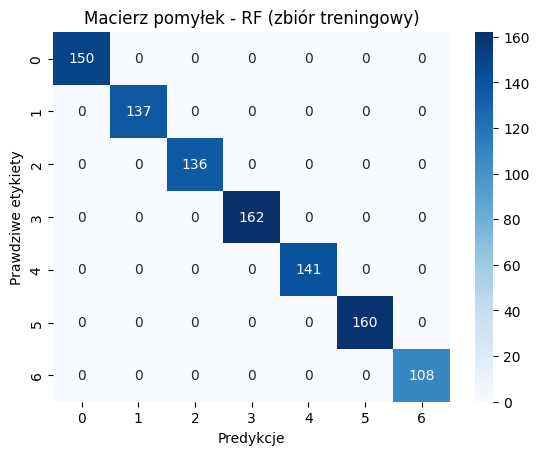


Accuracy (train RF): 1.0


In [117]:
# tutaj też przedstawimy macierze pomyłek
# najpierw dla zbioru treningowego
rf_train = confusion_matrix(y_train, rf_classifier.predict(X_train))
sns.heatmap(rf_train, annot=True, fmt='d', cmap='Blues')
plt.title('Macierz pomyłek - RF (zbiór treningowy)')
plt.xlabel('Predykcje')
plt.ylabel('Prawdziwe etykiety')
plt.show()
print('\nAccuracy (train RF):', accuracy_score(y_train, rf_classifier.predict(X_train)))

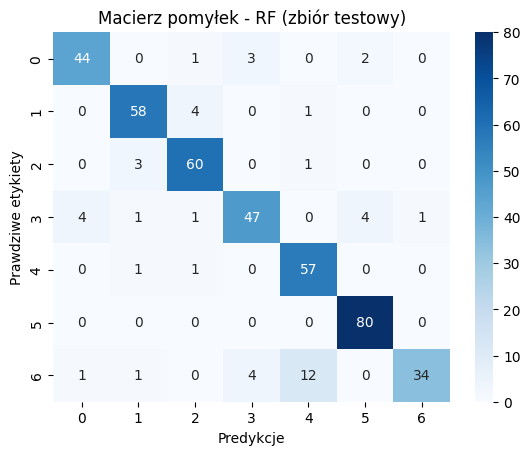


Accuracy (test RF): 0.892018779342723


In [118]:
# dla zbioru testowego
rf_test = confusion_matrix(y_test, rf_classifier.predict(X_test))
sns.heatmap(rf_test, annot=True, fmt='d', cmap='Blues')
plt.title('Macierz pomyłek - RF (zbiór testowy)')
plt.xlabel('Predykcje')
plt.ylabel('Prawdziwe etykiety')
plt.show()
print('\nAccuracy (test RF):', accuracy_score(y_test, rf_classifier.predict(X_test)))
# najgorzej poradził sobie z rozróżnieniem klasy square i triangle (4 i 6)

# Podsumowanie
Zostało przeprowadzone uczenie maszynowe na zbiorze danych z obrazkami narysowanych odręcznie figur. Modele, które wykorzystano to maszyna wektorów wspierających (SVM) oraz las losowy (Random Forest). Oba klasyfikatory poradziły sobie bardzo dobrze ze zbiorem, lepiej maszyna wektorów a nieco gorzej las losowy. Modele nie były ani przeuczone ani niedouczone. 